# Keras Time-Series Anomaly Detection


https://keras.io/examples/timeseries/timeseries_anomaly_detection/

https://www.kaggle.com/datasets/boltzmannbrain/nab?resource=download

https://towardsdatascience.com/anomaly-detection-using-autoencoders-5b032178a1ea

https://www.statology.org/high-dimensional-data/

[1]: https://stats.stackexchange.com/questions/262044/what-does-a-bottleneck-layer-mean-in-neural-networks

https://stackoverflow.com/questions/44334348/low-and-high-dimensional-data

[2]: https://www.baeldung.com/cs/dl-latent-space#:~:text=Definition,other%20in%20the%20latent%20space.

This script demonstrates how you can use a reconstruction convolutional autoencoder model to detect anomalies in timeseries data.


An AutoEncoder model is a generative unsupervised deep learning algorithm used for reconstructing high-dimensional input data (or data which has more features than observations),  using a neural network with a narrow bottleneck layer in the middle which contains the latent representation of the input data.

![](https://www.statology.org/wp-content/uploads/2021/02/highDim1-768x200.png)

A narrow bottleneck layer basically means that the layer has fewer nodes and this can be used to obtain a representation of the input with reduced dimensionality. [1]

An Autoencoder consists of an Encoder and a Decoder.

## Encoder network: 
Accepts high-dimensional input data and translates it to latent low-dimensional data (data which has more observations than features). An example of low dimensional data would be the well-known Fishers' iris dataset.  The input size to an Encoder network is larger than its output size.

## Decoder network:
The Decoder network receives the input from the Encoder coder’s output, and its objective is to reconstruct the input data. The output size of a Decoder network is larger than its input size.

So, the Autoencoder accepts high-dimensional input data, compresses it down to the latent-space representation in the bottleneck hidden layer; the Decoder takes the latent representation of the data as an input to reconstruct the original input data.

## Latent Space 
Formally, a latent space is defined as an abstract multi-dimensional space that encodes a meaningful internal representation of externally observed events. [2] Samples that are similar in the external world are positioned close to each other in the latent space.



# As far as here

To better understand the concept, let’s think about how humans perceive the world. We are able to understand a broad range of topics by encoding each observed event in a compressed representation in our brain.

For example, we don’t keep in mind every detail of the appearance of a dog to be able to recognize a dog in the street. As we can see in the illustration below, we keep an internal representation of the general appearance of a dog: In a similar way, the latent space tries to provide a compressed understanding of the world to a computer through a spatial representation.

Deep learning has revolutionized many aspects of our life with applications ranging from self-driving cars to predicting serious diseases. Its main goal is to transform the raw data (such as the pixel values of an image) into a suitable internal representation or feature vector from which the learning subsystem, often a classifier, could detect or classify patterns in the input. So, we realize that deep learning and latent space are strongly related concepts since the internal representations of the former constitute the latter.

As we can see below, a deep learning model takes as input raw data and outputs discriminative features that lie in a low-dimensional space referred to as latent space. These features are then used to solve various tasks like classification, regression, or reconstruction:
1 latent

To better understand the importance of latent space in deep learning, we should think of the following question: Why do we have to encode the raw data in a low-dimensional latent space before classification, regression, or reconstruction?

The answer is data compression. Specifically, in cases where our input data are high-dimensional, it is impossible to learn important information directly from the raw data.

For example, in an image classification task, the input dimensions could be 512 \times 512 \times 3 that correspond to 512*512*3=786,432 input pixels. It seems impossible for a system to learn useful patterns for classification by looking at so many values. The solution is to encode the high-dimensional input space to a low-dimensional latent space using a deep neural network.









Autoencoders Usage
Dimensionality Reduction. The Encoder encodes the input into the hidden layer to reduce the dimensionality of linear and nonlinear data; hence it is more powerful than PCA.
Recommendation Engines
Anomaly Detection: Autoencoders tries to minimize the reconstruction error as part of its training. Anomalies are detected by checking the magnitude of the reconstruction loss.
Denoising Images: An image that is corrupted can be restored to its original version.
Image recognition: Stacked autoencoder are used for image recognition by learning the different features of an image.
Image generation: Variational Autoencoder(VAE), a type of autoencoders, is used to generate images.
Read about different types of Autoencoder here.

Anomaly detection using Autoencoders
Follow the following steps to detect anomalies in a high-dimension dataset. You can apply this to unbalanced datasets too.

During the training, input only normal transactions to the Encoder. The bottleneck layer will learn the latent representation of the normal input data.
The Decoder will use the bottleneck layers output to reconstruct the normal transactions of the original input data.
A fraudulent transaction will be different from a normal transaction. The Autoencoder will have trouble reconstructing the fraudulent transaction, and hence the reconstruction error will be high.
You can flag a new transaction is fraudulent based on a specified threshold value for the reconstruction error.



In [1]:
# Importing required libraries 


import pandas as pd
import matplotlib.pyplot as plt
import  numpy as np 
import tensorflow.keras as keras
from tensorflow.keras import layers



2023-01-04 23:54:45.386661: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-01-04 23:54:45.597193: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-01-04 23:54:45.597295: I tensorflow/compiler/xla/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2023-01-04 23:54:46.457976: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2023-

In the Keras Time-Series Anomaly Detection example the user uses the *Numenta Anomaly Benchmark(NAB)* dataset. It provides artifical timeseries data containing labeled anomalous periods of behavior. Data are ordered, timestamped, single-valued metrics. 

Firstly, in order to get the data from the NAB dataset we must pull it from its github repository using the methods below

In [2]:

# Root of URLs.
root_url = 'https://raw.githubusercontent.com/numenta/NAB/master/data/'

# Data file without anomaly.
no_anomaly_url = root_url + 'artificialNoAnomaly/art_daily_small_noise.csv'

# Data file with anomaly.
with_anomaly_url = root_url + 'artificialWithAnomaly/art_daily_jumpsup.csv'



In [3]:
# Create the non-anomaly data set using Pandas 'read_csv()' function
no_anomaly = pd.read_csv(no_anomaly_url, parse_dates=True, index_col="timestamp")

# Print the first 5 rows to ensure that the data is importing correctly
print(no_anomaly.head())



                         value
timestamp                     
2014-04-01 00:00:00  18.324919
2014-04-01 00:05:00  21.970327
2014-04-01 00:10:00  18.624806
2014-04-01 00:15:00  21.953684
2014-04-01 00:20:00  21.909120


In [4]:
# Describe the dataframe
no_anomaly.describe()

,value
count,4032.000000
mean,42.438353
std,28.077122
min,18.000964
25%,19.841390
50%,21.608487
75%,75.450282
max,87.976128


The ```describe``` function return the mean, max and standard deviation among other variables. 

We will then plot the data to get an overall view of the dataset. 

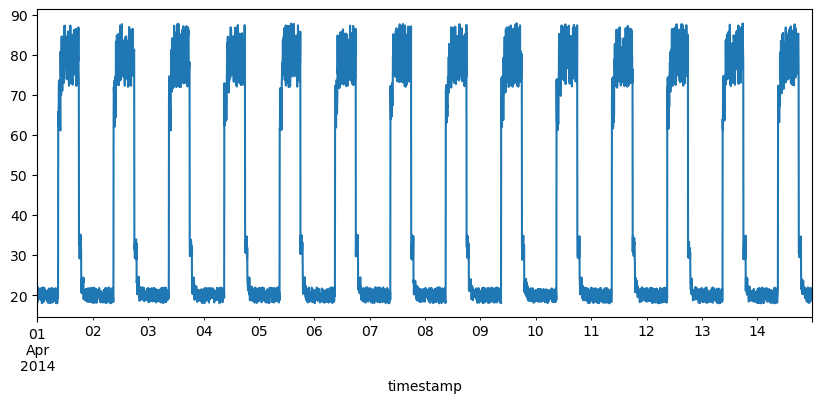

In [5]:
# Set the figsize for the dataset 
fig, ax = plt.subplots(figsize=(10,4))

# Use pandas to plot data frame.
no_anomaly.plot(legend=False, ax=ax);

In [6]:
# Getting the anomaly dataset 
with_anomaly= pd.read_csv(with_anomaly_url, parse_dates=True, index_col="timestamp")

In [7]:
# print first few rows to ensure that the data is imported correctly
print(with_anomaly.head())

                         value
timestamp                     
2014-04-01 00:00:00  19.761252
2014-04-01 00:05:00  20.500833
2014-04-01 00:10:00  19.961641
2014-04-01 00:15:00  21.490266
2014-04-01 00:20:00  20.187739


In [8]:
# Using the describe() function to get the mean, std,& min and max of the anomaly dataset
with_anomaly.describe()

,value
count,4032.000000
mean,44.494254
std,32.432473
min,18.001010
25%,19.991382
50%,21.648503
75%,76.435943
max,164.947481


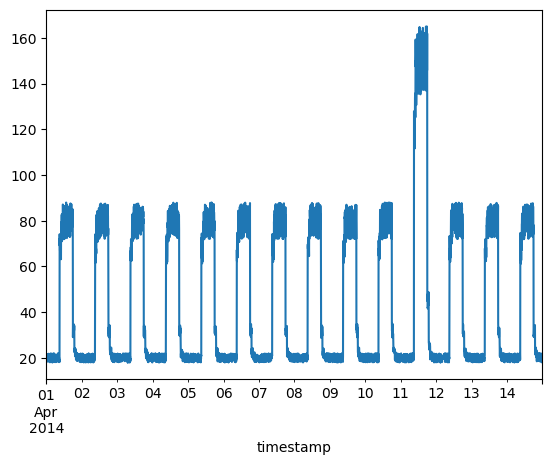

In [9]:
# Create a plot to show the data
fig, ax = plt.subplots()
with_anomaly.plot(legend=False, ax=ax)
plt.show()

We can see that the data has a large anomaly at the 11/12 April timestamp, compared to the non-anomaly dataset

# Preparing training data - As far as here


In [10]:
# Normalize and save the mean and std we get,
# for normalizing test data.
training_mean = no_anomaly.mean()



In [11]:
training_std = no_anomaly.std()

In [12]:
df_training_value = (no_anomaly - training_mean) / training_std
# 
df_training_value.head()

,value
timestamp,
2014-04-01 00:00:00,-0.858829
2014-04-01 00:05:00,-0.728993
2014-04-01 00:10:00,-0.848148
2014-04-01 00:15:00,-0.729586
2014-04-01 00:20:00,-0.731173


In [13]:
no_anomaly['less_mean'] = no_anomaly['value'] - no_anomaly['value'].mean()
no_anomaly['div_std'] = no_anomaly['less_mean'] / no_anomaly['value'].std()

In [14]:
no_anomaly

,value,less_mean,div_std
timestamp,,,
2014-04-01 00:00:00,18.324919,-24.113435,-0.858829
2014-04-01 00:05:00,21.970327,-20.468026,-0.728993
2014-04-01 00:10:00,18.624806,-23.813547,-0.848148
2014-04-01 00:15:00,21.953684,-20.484669,-0.729586
2014-04-01 00:20:00,21.909120,-20.529234,-0.731173
...,...,...,...
2014-04-14 23:35:00,20.211195,-22.227159,-0.791647
2014-04-14 23:40:00,20.531041,-21.907313,-0.780255
2014-04-14 23:45:00,19.032127,-23.406226,-0.833640


In [15]:
no_anomaly['value'].mean(), no_anomaly['less_mean'].mean(), no_anomaly['div_std'].mean()

(42.438353335806646, -7.342627387941552e-14, -2.616541242931684e-15)

In [16]:
no_anomaly['value'].std(), no_anomaly['less_mean'].std(), no_anomaly['div_std'].std()

(28.077122281262515, 28.077122281262508, 1.0000000000000018)

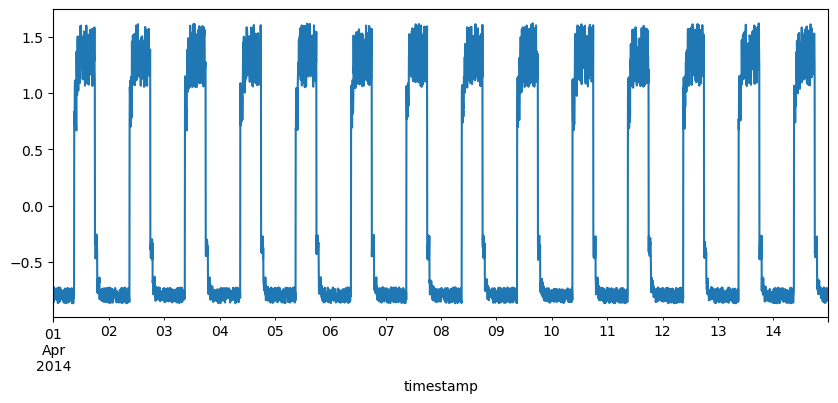

In [17]:
# 
fig, ax = plt.subplots(figsize=(10,4))

# Use pandas to plot data frame.
df_training_value.plot(legend=False, ax=ax);

In [18]:
window_size = 288
#Window example:

#[1, 1, 2, 4, 5, 6, 7, 1, 2, 3, 4, 5]
#window_size = 3
#[1, 1, 2]
#[1, 2, 4]
#[2, 4, 5]
#[4, 5, 6]



In [19]:
# Window list example.
L = [1, 1, 2, 4, 5, 6, 7, 1, 2, 3, 4, 5]

In [20]:
# Example window size.
win_size = 3

In [21]:
# Length of L.
len(L)
12

12

In [22]:
# Remove brackets.
len(L) - win_size + 1

# Print the windows.
for i in range(len(L) - win_size + 1):
    print(L[i:i + win_size])

[1, 1, 2]
[1, 2, 4]
[2, 4, 5]
[4, 5, 6]
[5, 6, 7]
[6, 7, 1]
[7, 1, 2]
[1, 2, 3]
[2, 3, 4]
[3, 4, 5]


In [23]:
wins = []

# Generate the windows
for i in range(len(L) - win_size + 1):
    wins.append(L[i:i + win_size])


In [24]:
np.stack(wins)

array([[1, 1, 2],
       [1, 2, 4],
       [2, 4, 5],
       [4, 5, 6],
       [5, 6, 7],
       [6, 7, 1],
       [7, 1, 2],
       [1, 2, 3],
       [2, 3, 4],
       [3, 4, 5]])

In [25]:
def windows(vals, N=window_size):
  # 
  L = []
  # 
  for i in range(len(vals) - N + 1):
    # 
    L.append(vals[i:i+N])
  # Stack
  return np.stack(L)

In [26]:
x_train = windows(df_training_value)
# 
x_train[0][0], x_train[-1][-1]

(array([-0.85882857]), array([-0.8460886]))

In [27]:
#
df_training_value['value'].values

# 
x_train[0].flatten()

array([-0.85882857, -0.72899302, -0.84814772, -0.72958579, -0.731173  ,
       -0.75730984, -0.77645641, -0.7880838 , -0.747012  , -0.829166  ,
       -0.80377285, -0.7821597 , -0.81182078, -0.80949918, -0.82334701,
       -0.79001779, -0.74922405, -0.84169024, -0.73727717, -0.77223023,
       -0.75311352, -0.79116337, -0.75934728, -0.86809294, -0.75381057,
       -0.86468256, -0.74361965, -0.72908121, -0.82850668, -0.84043795,
       -0.76136364, -0.8343536 , -0.74708881, -0.85574949, -0.85245676,
       -0.73090636, -0.77440264, -0.74974936, -0.82419543, -0.77402585,
       -0.78574242, -0.7844733 , -0.77316412, -0.78843253, -0.80927467,
       -0.83109167, -0.76090519, -0.83816509, -0.77176485, -0.83715923,
       -0.78131343, -0.76396862, -0.83924191, -0.86186112, -0.85174179,
       -0.78406773, -0.74938477, -0.86399047, -0.76581026, -0.82177506,
       -0.80222751, -0.73807119, -0.82310669, -0.80410682, -0.86845167,
       -0.85877599, -0.83356075, -0.86643297, -0.78045221, -0.80

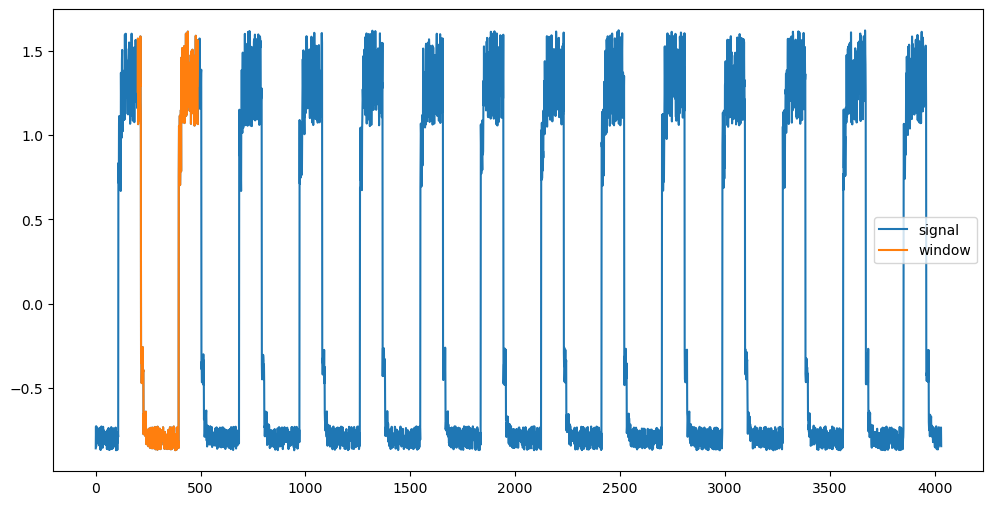

In [28]:
# 
window_no = 200

# 
fig, ax = plt.subplots(figsize=(12, 6))

# 
y = df_training_value['value'].values

# 
ax.plot(np.arange(y.shape[0]), y, label='signal')

# The first window.
w = x_train[window_no].flatten()

# 
ax.plot(np.arange(w.shape[0]) + window_no, w, label='window')

ax.legend();

In [29]:
TIME_STEPS = 288

# Generated training sequences for use in the model.
def create_sequences(values, time_steps=TIME_STEPS):
    output = []
    for i in range(len(values) - time_steps + 1):
        output.append(values[i : (i + time_steps)])
    return np.stack(output)


x_train = create_sequences(df_training_value.values)
print("Training input shape: ", x_train.shape)

Training input shape:  (3745, 288, 1)


In [30]:
#
layers = [
  #
  keras.layers.Input(shape=(x_train.shape[1], x_train.shape[2])),
  #
  keras.layers.Conv1D(
    filters=32, kernel_size=7, padding="same", strides=2, activation="relu"),
  #
  keras.layers.Dropout(rate=0.2),
  #
  keras.layers.Conv1D(
    filters=16, kernel_size=7, padding="same", strides=2, activation="relu"),
  #
  keras.layers.Conv1DTranspose(
    filters=16, kernel_size=7, padding="same", strides=2, activation="relu"),
  #
  keras.layers.Dropout(rate=0.2),
  #
  keras.layers.Conv1DTranspose(
    filters=32, kernel_size=7, padding="same", strides=2, activation="relu"),
  #
  keras.layers.Conv1DTranspose(filters=1, kernel_size=7, padding="same"),
]


In [31]:
#
model = keras.Sequential(layers)


2023-01-04 23:53:02.451924: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2023-01-04 23:53:02.451981: W tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:265] failed call to cuInit: UNKNOWN ERROR (303)
2023-01-04 23:53:02.452078: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (penguin): /proc/driver/nvidia/version does not exist
2023-01-04 23:53:02.463986: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [32]:
# 
optimizer = keras.optimizers.Adam(learning_rate=0.001)
# 


In [33]:
model.compile(optimizer=optimizer, loss="mse")


In [34]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 144, 32)           256       
                                                                 
 dropout (Dropout)           (None, 144, 32)           0         
                                                                 
 conv1d_1 (Conv1D)           (None, 72, 16)            3600      
                                                                 
 conv1d_transpose (Conv1DTra  (None, 144, 16)          1808      
 nspose)                                                         
                                                                 
 dropout_1 (Dropout)         (None, 144, 16)           0         
                                                                 
 conv1d_transpose_1 (Conv1DT  (None, 288, 32)          3616      
 ranspose)                                              

In [ ]:
history = model.fit(
    x_train,
    x_train,
    epochs=50,
    batch_size=128,
    validation_split=0.1,
    callbacks=[
        keras.callbacks.EarlyStopping(monitor="val_loss", patience=5, mode="min")
    ],
)



Epoch 1/50
27/27 [==============================] - 4s 90ms/step - loss: 0.5663 - val_loss: 0.0853
Epoch 2/50
27/27 [==============================] - 2s 69ms/step - loss: 0.0797 - val_loss: 0.0396
Epoch 3/50
27/27 [==============================] - 2s 66ms/step - loss: 0.0572 - val_loss: 0.0346
Epoch 4/50
27/27 [==============================] - 2s 63ms/step - loss: 0.0486 - val_loss: 0.0303
Epoch 5/50
27/27 [==============================] - 2s 69ms/step - loss: 0.0430 - val_loss: 0.0276
Epoch 6/50
27/27 [==============================] - 2s 72ms/step - loss: 0.0383 - val_loss: 0.0248
Epoch 7/50
27/27 [==============================] - 2s 74ms/step - loss: 0.0340 - val_loss: 0.0222
Epoch 8/50
27/27 [==============================] - 2s 63ms/step - loss: 0.0305 - val_loss: 0.0199
Epoch 9/50
27/27 [==============================] - 2s 66ms/step - loss: 0.0277 - val_loss: 0.0196
Epoch 10/50
27/27 [==============================] - 2s 68ms/step - loss: 0.0256 - val_loss: 0.0187
Epoch 11/

In [ ]:
history.history["loss"]

In [ ]:
history.history["val_loss"]

In [ ]:
# 
fig, ax = plt.subplots(figsize=(10, 6))
# 
ax.plot(history.history["loss"], label="Training Loss")
# 
ax.plot(history.history["val_loss"], label="Validation Loss")
# 
ax.legend();

Anomaly detection 

In [ ]:
# Get train MAE loss.
x_train_pred = model.predict(x_train)






In [ ]:
# Calculate loss...
train_mae_loss = np.mean(np.abs(x_train_pred - x_train), axis=1)


In [ ]:
# 
fig, ax = plt.subplots(figsize=(10, 6))
# 
ax.hist(train_mae_loss, bins=50)
# 
ax.set_xlabel("Train MAE loss")
#
ax.set_ylabel("No of samples");

In [ ]:
# Get reconstruction loss threshold.
threshold = np.max(train_mae_loss)
print("Reconstruction error threshold: ", threshold)


In [ ]:
# 
fig, ax = plt.subplots(figsize=(10, 6))

# 
ax.plot(x_train[0])

# 
ax.plot(x_train_pred[0]);


prepare test data


In [ ]:
# 
df_test_value = (with_anomaly- training_mean) / training_std
# 
fig, ax = plt.subplots(figsize=(10, 6))

# 
df_test_value.plot(legend=False, ax=ax);


In [ ]:
# Create sequences from test values.
x_test = windows(df_test_value.values)

x_test.shape
(3745, 288, 1)






In [ ]:
# 
x_test_pred = model.predict(x_test)



In [ ]:
# 
test_mae_loss = np.mean(np.abs(x_test_pred - x_test), axis=1)

test_mae_loss




In [ ]:
# 
test_mae_loss = test_mae_loss.reshape((-1))

test_mae_loss

In [ ]:
# 
fig, ax = plt.subplots(figsize=(10, 6))

#
ax.hist(test_mae_loss, bins=50)

# 
ax.set_xlabel("test MAE loss")

# 
ax.set_ylabel("No of samples");

In [ ]:
# Detect all the samples which are anomalies.
anomalies = test_mae_loss > threshold

# NUmber of anomalies.
np.sum(anomalies)

In [ ]:
# data i is an anomaly if samples [(i - timesteps + 1) to (i)] are anomalies
inds = []

for i in range(window_size - 1, len(df_test_value) - window_size + 1):
    if np.all(anomalies[i - window_size + 1 : i]):
        inds.append(i)

In [ ]:
# 
df_subset = df_daily_jumpsup.iloc[inds]


In [ ]:
#
fig, ax = plt.subplots(figsize=(10, 6))

# 
df_daily_jumpsup.plot(legend=False, ax=ax)

# 
df_subset.plot(legend=False, ax=ax, color="r");